# Setup

## Goal

Can I create the 7th energy level of a Quantum Harmonic Oscillator, defined by $H = \frac{P^2}{2m} + \frac{1}{2}m \omega^2 X^2$, by fine tuning the $\omega$ parameter to follow a $\omega_t$ evolution?

## Imports

In [1]:
from copy import deepcopy
from matplotlib import pyplot as plt
import numpy as np
import scipy
import seaborn as sns
import torch

plt.figure(figsize=(20,3))

<Figure size 2000x300 with 0 Axes>

<Figure size 2000x300 with 0 Axes>

## Setup CUDA usage

In [2]:
# https://github.com/pytorch/tutorials/issues/3263#issue-2811049983

device_name = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
    device_name = torch.cuda.get_device_name(0)
else:
    device = torch.device("cpu")
    # device_name = torch.cpu ... # TODO: Find the cpu device name

torch.set_default_device(device)
print(f"Using {device} device: {device_name}")

Using cuda device: NVIDIA GeForce RTX 3050 Ti Laptop GPU


## Global settings

In [3]:
n_time_intervals:int = 20
number_of_energy_levels:int = 20
omega:float = 10.
resolution:int = 1000
target_energy_level:int = 9
time_delta:float = 1.
total_evolution_time:float = time_delta * n_time_intervals
x_max:float = 2.
x_min:float = -2.

# Hilbert space

In [4]:
valid_x = torch.linspace(x_min, x_max, resolution)
delta_x = valid_x[1] - valid_x[0]

def potential(x):
    return x**2

## Potential

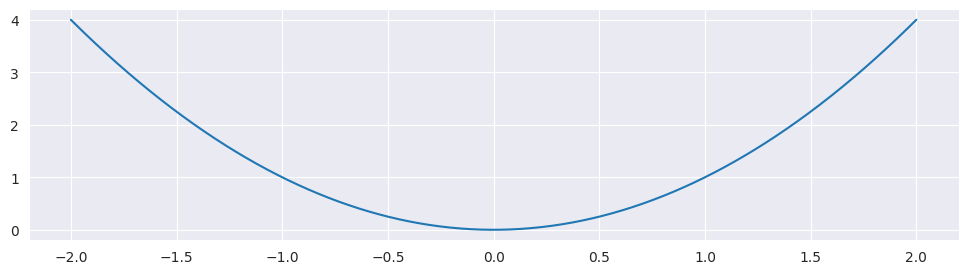

In [5]:
plt.figure(figsize=(12,3))
plt.plot(valid_x.cpu(), potential(valid_x.cpu()))

## Hamiltonian

In [6]:
def generate_hamiltonian(omega: torch.Tensor | float, center: torch.Tensor | float=torch.tensor(0)) -> torch.Tensor:

    return 2 * torch.diag(torch.ones(resolution)) / delta_x**2 \
- (( torch.diag(torch.ones(resolution - 1), diagonal=1) + torch.diag(torch.ones(resolution - 1), diagonal=-1)) / delta_x**2) \
+ torch.diag(torch.tensor([.5 * (omega*x)**2 for x in valid_x]))

hamiltonian = generate_hamiltonian(omega=omega)

## Energy levels

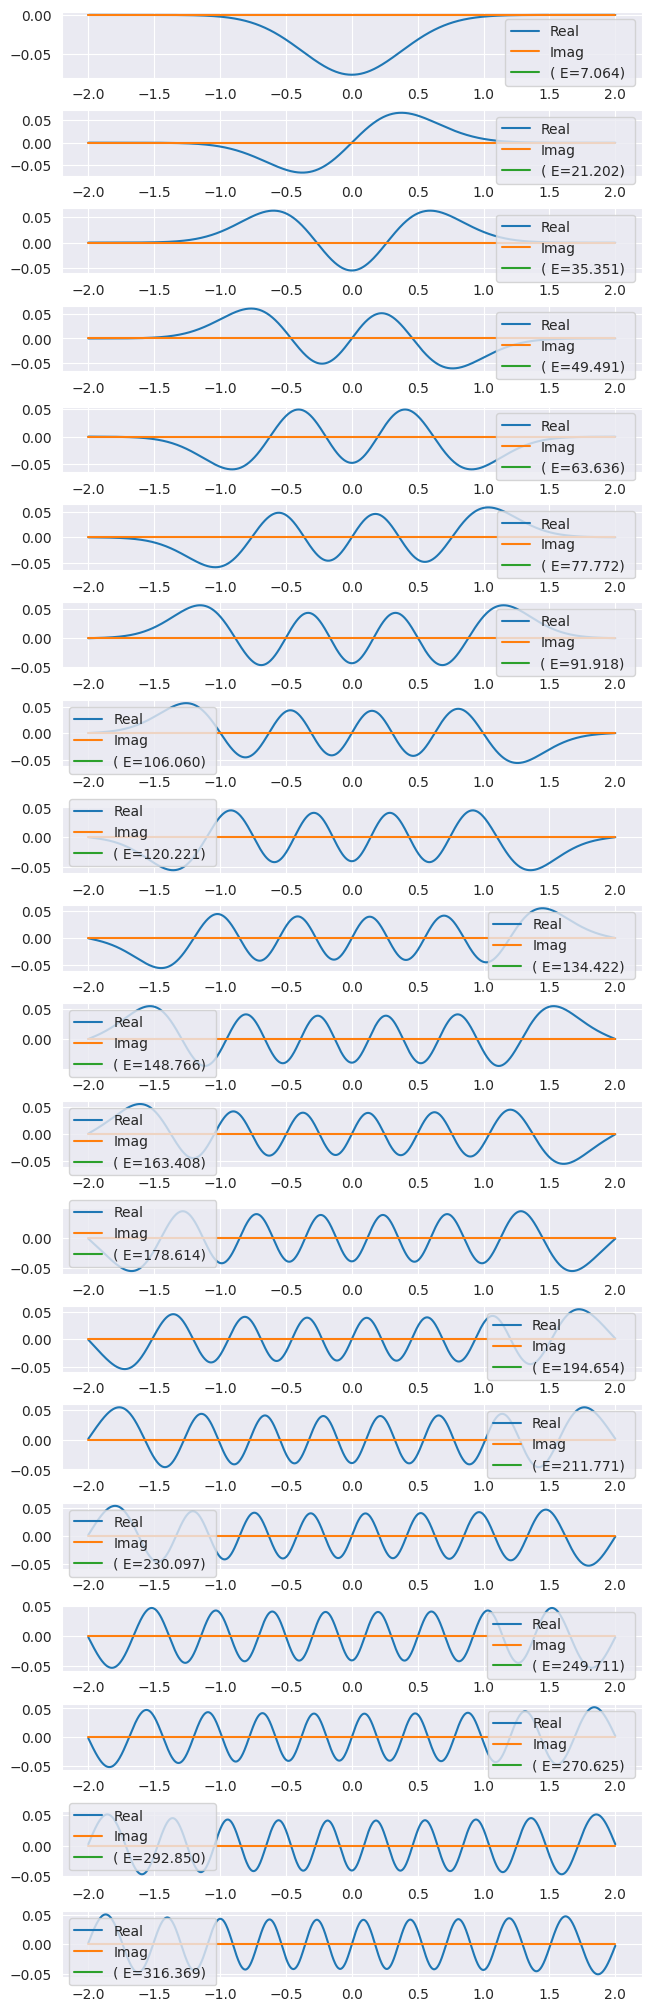

In [7]:
eigenvalues, eigenvectors = torch.linalg.eigh(hamiltonian)
eigenvalues = eigenvalues[:number_of_energy_levels]
eigenvectors = torch.transpose(eigenvectors, dim0=0, dim1=1)[:number_of_energy_levels]

fig, axes = plt.subplots(number_of_energy_levels, 1, layout='constrained')
fig.set_figheight(number_of_energy_levels)
for i, (val, vector) in enumerate(zip(eigenvalues, eigenvectors)):
    axes[i].plot(valid_x.cpu().numpy(), np.real(vector.cpu().numpy()), label=f"Real")
    axes[i].plot(valid_x.cpu().numpy(), np.imag(vector.cpu().numpy()), label=f"Imag")
    axes[i].plot([],[], label=f"( E={np.real(val):.3f}) ")
    axes[i].legend(loc='best')

plt.show()

## Orthonormality check

<Axes: >

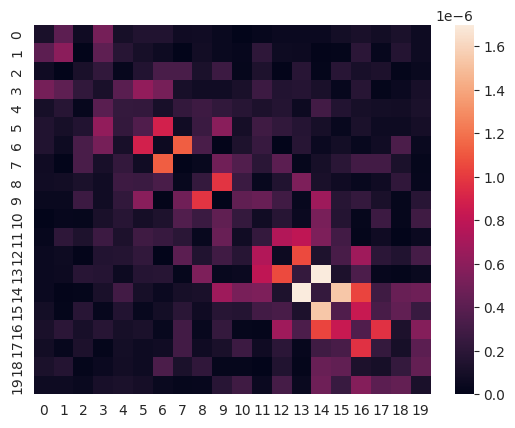

In [8]:
# Ideally this should all be zeroes
error_matrix = torch.abs(eigenvectors @ torch.transpose(eigenvectors, dim0=0, dim1=1)) - torch.eye(number_of_energy_levels)
sns.heatmap(np.abs(error_matrix.cpu().numpy()))

## Origin state

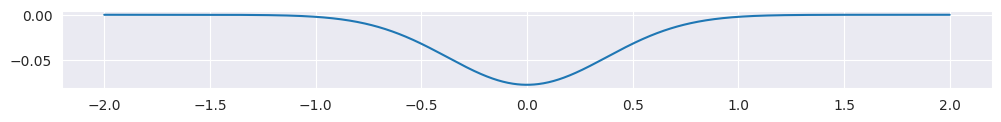

In [9]:
origin_state = eigenvectors[0, :].clone().type(torch.complex64)
plt.figure(figsize=(12,1))
plt.plot(valid_x.cpu(), np.real(origin_state.cpu().clone().detach()))

## Target state

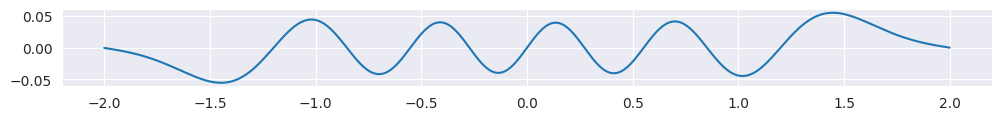

In [10]:
target_state = eigenvectors[target_energy_level, :].clone().type(torch.complex64)
plt.figure(figsize=(12,1))
plt.plot(valid_x.cpu(), np.real(target_state.cpu().clone().detach()))

## Fidelity
$\mathcal{F} \coloneqq |\braket{\rho_a | \rho_b} |^2$

In [11]:
def fidelity(state_a: torch.Tensor, state_b: torch.Tensor) -> torch.Tensor:
    return torch.div(
        torch.abs(torch.tensordot(state_a, state_b, dims=1)),
        torch.mul(
            torch.norm(state_a, p=2),
            torch.norm(state_b, p=2)
        )
    )**2

# Auxiliary functions

We will split the time evolution into time_intervals. We want to find a vector of time choices that maximizes the final fidelity between the target state, and the evolved state

In [12]:
x_squared = torch.tensor([x**2 for x in valid_x])
x_linear = torch.tensor([x for x in valid_x])

In [13]:
class HarmonicEvolutionLayer(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.omega = torch.nn.Parameter(1.2 * omega * torch.rand(()), requires_grad=True)
        self.center = torch.nn.Parameter((torch.rand(()) - .5) * x_max, requires_grad=True)
        self.time = torch.nn.Parameter(time_delta * torch.rand(()), requires_grad=True)
        self.linear_x = x_linear.detach().clone()
        self.squared_x = x_squared.detach().clone()

    def forward(self, x): # x is our quantum state
        momentum_component = torch.subtract(
            torch.multiply(
                torch.Tensor(2 / delta_x**2),
                torch.diag(torch.ones(resolution))
            ),
            torch.divide(
                torch.add(
                    torch.diag(torch.ones(resolution - 1), diagonal=1),
                    torch.diag(torch.ones(resolution - 1), diagonal=-1)
                ),
                torch.Tensor(delta_x **2)
            )
        )
        potential_component = torch.diag(
            torch.multiply(
                torch.multiply(self.omega**2, -1),
                torch.subtract(
                    .5 * torch.add(self.squared_x, self.center**2),
                    self.center * self.linear_x
                )
            )
        ) # - .5 ( omega^2 (x-c)^2 ) = omega^2 ( x^2 + c^2 - .5xc )

        layer_hamiltonian = torch.add(momentum_component, potential_component)
        unitary = torch.linalg.matrix_exp(-1j * self.time * layer_hamiltonian)
        y = torch.matmul(unitary, x) # TODO: Use torch.nn.LayerNorm instead
        return torch.div(y, torch.norm(y, p=2))
        # return self.omega ** 2 * (x - self.center)**2

    def string(self):
        return f"e^(iH*{self.time:.3f}), V(x) = .5 * ( {self.omega:.2f}^2 (x - {self.center:.2f})^2)"

## Model construction

In [14]:
model = torch.nn.Sequential()
model.cuda()
for i in range(n_time_intervals):
    model.add_module(f"H{i}", HarmonicEvolutionLayer())

## Model plan via Torchviz

In [15]:
# from torchviz import make_dot
# make_dot(
#     model(origin_state),
#     params=dict(model.named_parameters()),
#     # show_attrs=True,
#     # show_saved=True
# )

## Loss function

In [16]:
def loss_function(
        internal_evolved_state: torch.Tensor,
        # internal_omega_list: torch.Tensor,
        # internal_time_list: torch.Tensor,
        internal_target_state: torch.Tensor
) -> torch.Tensor:
    fidelity_loss = torch.subtract(
            fidelity(internal_evolved_state, internal_target_state),
            1
        )**2

    imaginary_component = torch.mul(
        torch.subtract(
            2 * torch.norm(torch.imag(internal_evolved_state), p=2),
            1
        )**2,
        1e-1
    )

    normalization_error = 1e-1 * torch.square(torch.subtract(
        torch.norm(internal_evolved_state, p=2),
        torch.tensor(1)
    ))

    return torch.add(
        torch.add(
            fidelity_loss,
            imaginary_component
        ),
        normalization_error
    )

# TODO: Have this as a regularizer
# We want to regularize the total time
# We want to regularize the omegas/etc in each layer
# time_loss = 10**-4 * torch.math.divide(torch.math.reduce_sum(internal_time_list) - total_evolution_time, total_evolution_time)**2
#
# negative_time_loss = -1 * 10**3 * np.min([np.min(internal_time_list), 0])
# negative_omega_loss = -1 * 10**3 * np.min([np.min(internal_omega_list), 0])
# large_omega_loss = 10**-4 * np.max(internal_omega_list)**2

In [17]:
# torch.nn.CrossEntropyLoss(loss_function)

## Set optimizer

In [18]:
# optimizer = torch.optim.SGD(
#     model.parameters(),
#     lr=1e-1,
#     momentum=1e-3,
#     # dampening=1,
#     # weight_decay=1e-12
# )


In [19]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3, #TODO: Optimize the learning rate https://discuss.pytorch.org/t/get-the-best-learning-rate-automatically/58269/4
    # fused=True
    # betas=(0.9, 0.999),
    # dampening=1,
    # weight_decay=1e-12
)

# Optimize

In [20]:
for t in range(10000):

    evolved_state = model(origin_state)
    loss = loss_function(internal_evolved_state=evolved_state, internal_target_state=target_state)

    if t % 10 == 0:
        phi_imag:float = torch.norm(torch.imag(evolved_state), p=2) ** 2
        phi_real:float = torch.norm(torch.real(evolved_state), p=2) ** 2
        print(f"{t}: Fid:{100*fidelity(target_state, evolved_state):.2f}% (Im:{100 * phi_imag:.2f}%, Re:{100*phi_real:.2f}%)")
        # + "<" + "|".join([f"{param.data:.1f}" for name, param in model.named_parameters()]) + ">")
        # I do not need to know the parameter values during training

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

0: Fid:1.58% (Im:44.13%, Re:55.87%)
10: Fid:37.92% (Im:47.18%, Re:52.82%)
20: Fid:57.98% (Im:25.31%, Re:74.69%)
30: Fid:63.29% (Im:25.61%, Re:74.39%)
40: Fid:66.44% (Im:31.47%, Re:68.53%)
50: Fid:69.03% (Im:27.11%, Re:72.89%)
60: Fid:71.23% (Im:27.41%, Re:72.59%)


KeyboardInterrupt: 

## Quick plot comparison

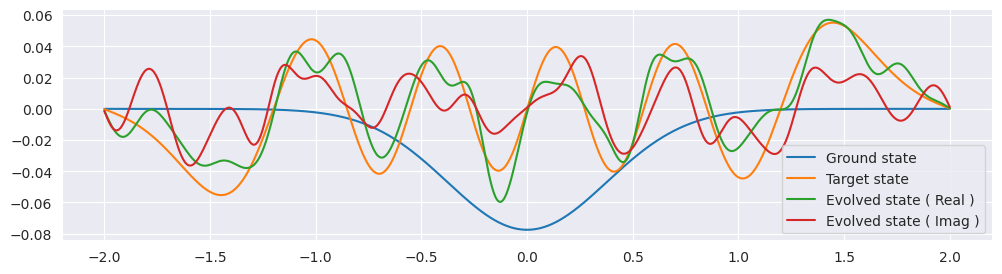

In [22]:
target_state = eigenvectors[target_energy_level, :].clone().type(torch.complex64)
plt.figure(figsize=(12,3))
plt.plot(valid_x.cpu(), np.real(origin_state.cpu().clone().detach()), label=f"Ground state")
plt.plot(valid_x.cpu(), np.real(target_state.cpu().clone().detach()), label=f"Target state")
plt.plot(valid_x.cpu(), np.real(model(origin_state).cpu().clone().detach()), label=f"Evolved state ( Real )")
plt.plot(valid_x.cpu(), np.imag(model(origin_state).cpu().clone().detach()), label=f"Evolved state ( Imag )")
plt.legend(loc='best')

plt.show()

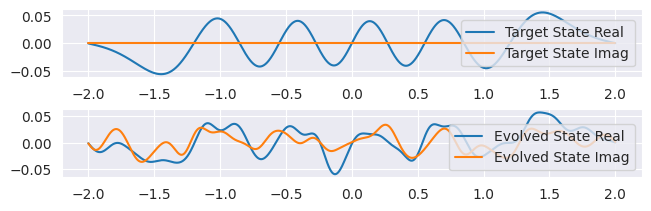

In [23]:
from matplotlib import pyplot as plt

fig, axes = plt.subplots(2, 1, layout='constrained')
fig.set_figheight(2)
axes[0].plot(
    valid_x.cpu().numpy(),
    np.real(target_state.cpu().clone().detach()),
    label="Target State Real"
)
axes[0].plot(
    valid_x.cpu().numpy(),
    np.imag(target_state.cpu().clone().detach()),
    label="Target State Imag"
)
axes[0].legend(loc='best')
axes[1].plot(
    valid_x.cpu().numpy(),
    np.real(model(origin_state).cpu().clone().detach()),
    label=f"Evolved State Real"
)
axes[1].plot(
    valid_x.cpu().numpy(),
    np.imag(model(origin_state).cpu().clone().detach()),
    label=f"Evolved State Imag"
)
axes[1].legend(loc='best')

plt.show()


# Optimal parameters

In [24]:
for name, param in model.named_parameters():
    print(f"{name}: {param.data:.3f}")

H0.omega: 11.876
H0.center: -0.820
H0.time: 0.279
H1.omega: 4.703
H1.center: -0.904
H1.time: 0.503
H2.omega: 4.421
H2.center: -0.263
H2.time: 0.447
H3.omega: 0.215
H3.center: -0.572
H3.time: 0.520
H4.omega: 1.977
H4.center: 0.059
H4.time: 0.206
H5.omega: 9.392
H5.center: 0.500
H5.time: 0.533
H6.omega: 0.480
H6.center: 0.327
H6.time: 0.530
H7.omega: 6.201
H7.center: -0.282
H7.time: 0.441
H8.omega: 11.489
H8.center: -0.873
H8.time: 0.545
H9.omega: 4.061
H9.center: -0.661
H9.time: 0.756
H10.omega: 4.037
H10.center: -0.063
H10.time: 0.010
H11.omega: 11.487
H11.center: -0.321
H11.time: 0.541
H12.omega: 10.524
H12.center: 0.613
H12.time: 0.995
H13.omega: 10.812
H13.center: -0.802
H13.time: 0.316
H14.omega: 10.133
H14.center: -0.673
H14.time: 0.433
H15.omega: 4.033
H15.center: 0.200
H15.time: 0.882
H16.omega: 6.364
H16.center: -0.518
H16.time: 0.749
H17.omega: 2.546
H17.center: -0.110
H17.time: 0.139
H18.omega: 1.142
H18.center: 0.210
H18.time: 0.455
H19.omega: 5.491
H19.center: 0.206
H19.tim

## Extract values

In [25]:
final_omega_list = []
final_center_list = []
final_time_list = []
for i, layer in enumerate(model):
    omega, center, time = (
        list(model[i].parameters())[0].data.cpu().numpy(),
        list(model[i].parameters())[1].data.cpu().numpy(),
        list(model[i].parameters())[2].data.cpu().numpy()
    )
    final_omega_list.append(omega)
    final_center_list.append(center)
    final_time_list.append(time)

## Plotting function

In [26]:
def np_generate_hamiltonian(np_omega: float, np_center: float, np_valid_x: np.array) -> np.array:

    # P^2 term
    temp_hamiltonian = scipy.sparse.eye(resolution, resolution, format='lil') * 2
    for i in range(resolution - 1):
        temp_hamiltonian[i, i + 1] = -1
        temp_hamiltonian[i + 1, i] = -1

    # # Turns the space cyclic. Useful for modelling ring interferometry
    # inner_hamiltonian[0, resolution - 1] = -1
    # inner_hamiltonian[resolution - 1, 0] = -1

    np_delta_x = np_valid_x[1] - np_valid_x[0]
    temp_hamiltonian = np.divide(temp_hamiltonian, np_delta_x ** 2)

    # V(X) term
    for i in range(resolution):
        temp_hamiltonian[i, i] += 1/2 * np_omega**2 * (np_valid_x[i] - np_center)**2

    return temp_hamiltonian.tocsc()

In [27]:
def plot_waves(
    omega_list: np.array,
    center_list: np.array,
    time_list: np.array,
    show_fidelity:bool = True
) -> None:

    assert len(omega_list) == len(time_list), f"The length of omega_list does not match the length of time_list: {len(omega_list)}!={len(time_list)}"

    np_valid_x = valid_x.cpu().numpy()
    np_evolved_state = deepcopy(origin_state.cpu().numpy())
    np_target_state = deepcopy(target_state.cpu().numpy())
    fig, axes = plt.subplots(n_time_intervals + 1, 1, layout='constrained')
    fig.set_figheight(n_time_intervals * 2)
    axes[0].plot(np_valid_x, np.real(np_evolved_state), label="Real")
    axes[0].plot(np_valid_x, np.imag(np_evolved_state), label="Imag")
    np_fidelity = np.abs(np.dot(np_evolved_state, np_target_state))**2
    if show_fidelity:
        axes[0].plot([], [], label=f"$\\mathcal{{F}}={100*np_fidelity:.2f}$")
    axes[0].legend(loc="best")

    for i, (temp_omega, temp_center, temp_time) in enumerate(zip(omega_list, center_list, time_list)):
        temp_hamiltonian = np_generate_hamiltonian(
            np_omega=temp_omega,
            np_center=temp_center,
            np_valid_x=np_valid_x,
        )
        unitary = scipy.sparse.linalg.expm(-1j * temp_hamiltonian * temp_time)
        np_evolved_state = unitary * np_evolved_state
        axes[i+1].plot(np_valid_x, np.real(np_evolved_state), label="Real")
        axes[i+1].plot(np_valid_x, np.imag(np_evolved_state), label="Imag")
        axes[i+1].plot(np_valid_x, np.real(np_target_state), label="target")
        if show_fidelity:
            np_fidelity = np.abs(np.dot(np_evolved_state, np_target_state))**2

            axes[i+1].plot([], [], label=f"$\\mathcal{{F}}={100*np_fidelity:.2f}\\%$")
            axes[i+1].plot([] , [], label=f"$\\omega={temp_omega:.2f}$")
            axes[i+1].plot([] , [], label=f"$t={temp_time:.2f}$")
        axes[i+1].legend(loc="best")

# Evolution Plot

## omega

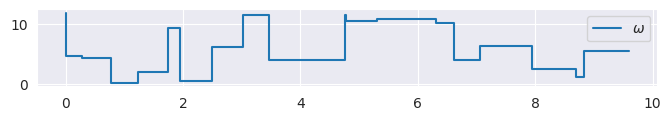

In [28]:
plt.figure(figsize=(8,1))
plt.step(
    np.concatenate((np.array([0]), np.cumsum(final_time_list))),
    np.concatenate((final_omega_list, np.array([final_omega_list[-1]]))),
    label="$\\omega$"
)
plt.legend(loc="best")

## center

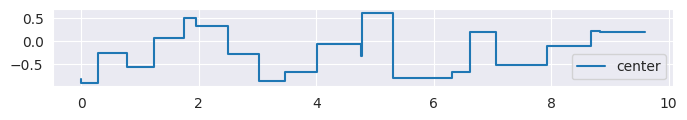

In [29]:
plt.figure(figsize=(8,1))
plt.step(
    np.concatenate((np.array([0]), np.cumsum(final_time_list))),
    np.concatenate((final_center_list, np.array([final_center_list[-1]]))),
    label="center"
)
plt.legend(loc="best")


## state

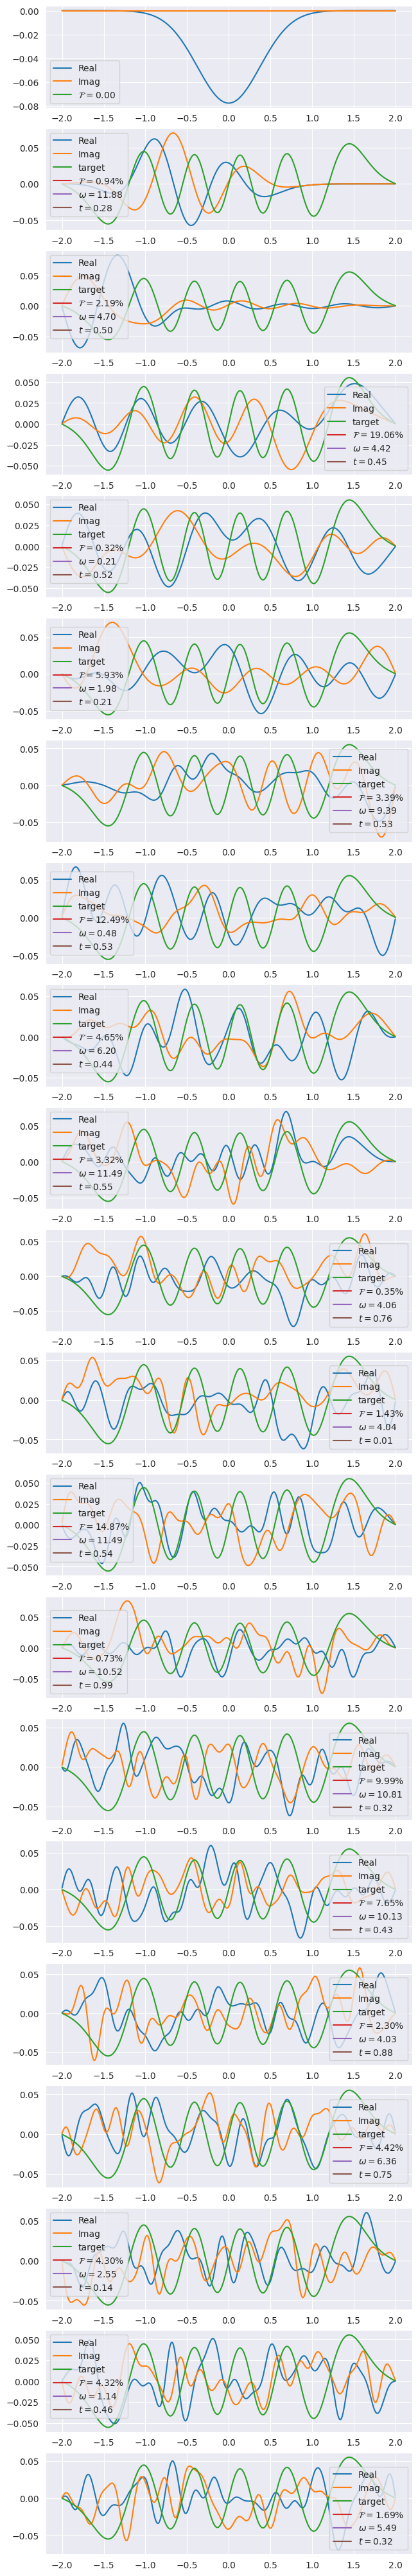

In [30]:
plot_waves(final_omega_list, final_center_list, final_time_list)